### Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import chi2_contingency

### Чтение данных

Немного подправим данные

In [2]:
data = pd.read_csv("М.Тех_Данные_к_ТЗ_DS.csv", encoding='cp1251')
data[['work_days', 'age', 'sex']] = data['Количество больничных дней,"Возраст","Пол"'].str.split(',', expand=True)
del data['Количество больничных дней,"Возраст","Пол"']

data['work_days'] = pd.to_numeric(data['work_days'])
data['age'] = pd.to_numeric(data['age'])

In [3]:
data['age_group'] = data['age'].apply(lambda x: '35 and younger' if x <= 35 else 'older than 35')
data['encoded'] = data['sex'].apply(lambda x: 1 if x == '"М"' else 0)
older_than_35_data = data[data['age'] > 35].reset_index(drop=True)
younger_than_35_data = data[data['age'] <= 35].reset_index(drop=True)

**Анализ данных**

In [4]:
data.isnull().any()

work_days    False
age          False
sex          False
age_group    False
encoded      False
dtype: bool

In [5]:
data[data['sex']=='"М"'].describe()

,work_days,age,encoded
count,139.000000,139.000000,139.0
mean,3.179856,39.899281,1.0
std,1.889144,6.797586,0.0
min,0.000000,23.000000,1.0
25%,2.000000,35.000000,1.0
50%,3.000000,41.000000,1.0
75%,4.000000,44.000000,1.0
max,8.000000,57.000000,1.0


In [6]:
data[data['sex']=='"Ж"'].describe()

,work_days,age,encoded
count,98.000000,98.000000,98.0
mean,3.367347,40.581633,0.0
std,1.689188,6.999151,0.0
min,0.000000,23.000000,0.0
25%,2.000000,36.000000,0.0
50%,3.000000,41.000000,0.0
75%,4.000000,45.000000,0.0
max,8.000000,60.000000,0.0


Интуитивно, отличия небольшие в распределении больничных дней между мужчинами и женщинами.

In [7]:
older_than_35_data.describe()

,work_days,age,encoded
count,180.000000,180.000000,180.000000
mean,3.227778,43.022222,0.561111
std,1.783946,4.979237,0.497636
min,0.000000,36.000000,0.000000
25%,2.000000,39.000000,0.000000
50%,3.000000,42.000000,1.000000
75%,4.000000,46.000000,1.000000
max,8.000000,60.000000,1.000000


In [8]:
younger_than_35_data.describe()

,work_days,age,encoded
count,57.000000,57.000000,57.000000
mean,3.350877,31.210526,0.666667
std,1.894458,3.478181,0.475595
min,0.000000,23.000000,0.000000
25%,2.000000,29.000000,0.000000
50%,3.000000,32.000000,1.000000
75%,4.000000,34.000000,1.000000
max,8.000000,35.000000,1.000000


И с разделением по возрасту также. Визуализируем данные.

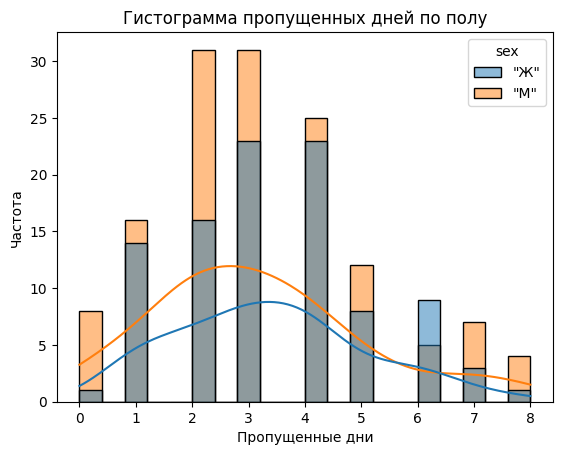

In [9]:
sns.histplot(data=data, x='work_days', hue='sex', bins=20, kde=True)
plt.title('Гистограмма пропущенных дней по полу')
plt.xlabel('Пропущенные дни')
plt.ylabel('Частота')
plt.show()

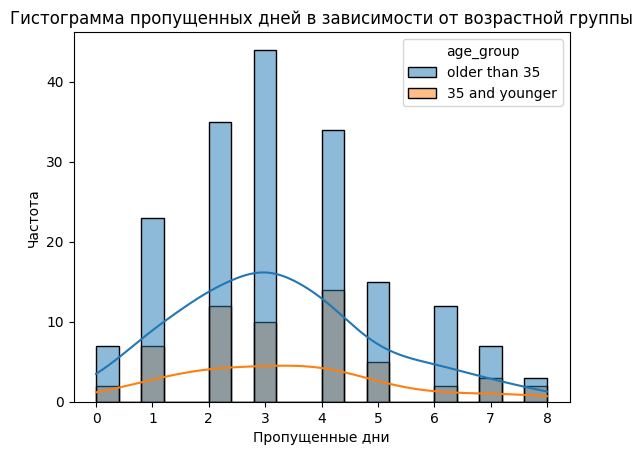

In [31]:
sns.histplot(data=data, x='work_days', hue='age_group', bins=20, kde=True)
plt.title('Гистограмма пропущенных дней в зависимости от возрастной группы')
plt.xlabel('Пропущенные дни')
plt.ylabel('Частота')
plt.show()


Видно, что люди постарше чаще пропускают дни, причем во всех периодах, но это не обязательно значит, что вторая гипотеза верна.

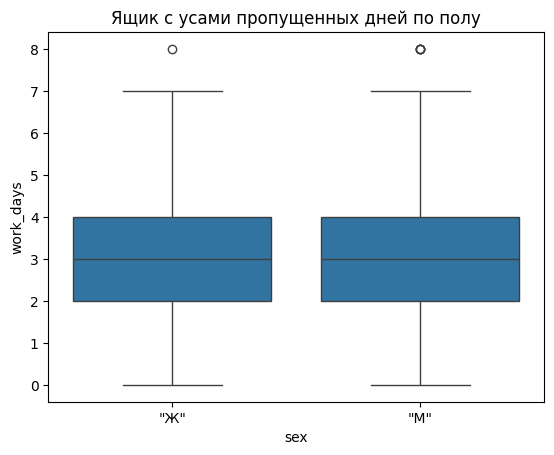

In [15]:
sns.boxplot(x='sex', y='work_days', data=data)
plt.title('Ящик с усами пропущенных дней по полу')
plt.show()

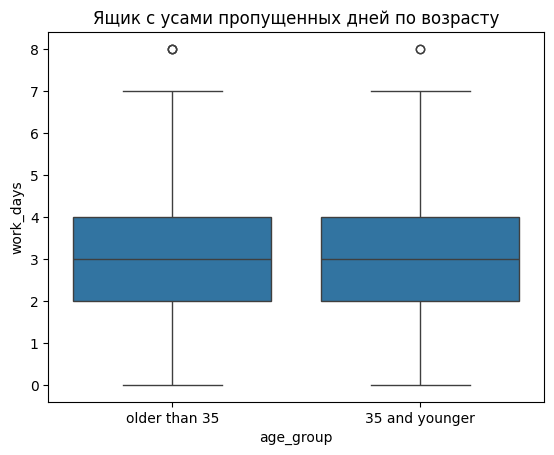

In [16]:
sns.boxplot(x='age_group', y='work_days', data=data)
plt.title('Ящик с усами пропущенных дней по возрасту')
plt.show()

Text(0.5, 1.0, 'Тепловая карта корреляции')

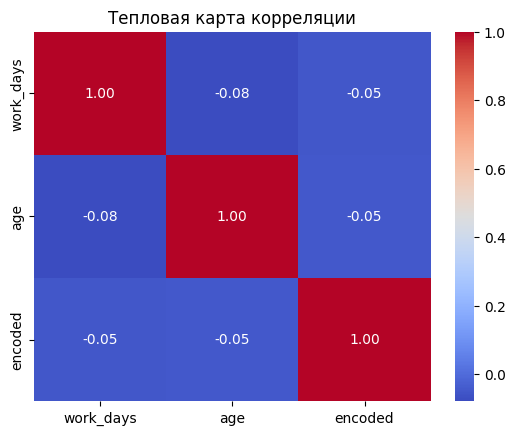

In [18]:
correlation_matrix = data[['work_days', 'age', 'encoded']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции')

Нет особой корреляции между признаками.

**Проверка данных на нормальность**

Так как нам необходимо будет тестировать гипотезы, хорошо бы было проверить данные на нормальное распределение. Используем критерий Андерсона-Дарлинга и Шапиро-Уилка.

Тест Андерсона-Дарлинга для проверки на нормальность распределения данных больничных дней мужчин и женщин:

In [19]:
result = anderson(data[data['sex'] == '"Ж"']['work_days'])

print("Статистика =", result.statistic)
print("Критические значения =", result.critical_values)
print("Уровни значимости =", result.significance_level)

# Проверка на нормальность с использованием уровня значимости 0.05
if result.statistic < result.critical_values[2]:
    print("Не удалось отвергнуть нулевую гипотезу. Данные могут быть нормально распределены.")
else:
    print("Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.")


Статистика = 1.8820469183320228
Критические значения = [0.555 0.632 0.758 0.884 1.052]
Уровни значимости = [15.  10.   5.   2.5  1. ]
Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.


In [20]:
result = anderson(data[data['sex'] == '"М"']['work_days'])

print("Статистика =", result.statistic)
print("Критические значения =", result.critical_values)
print("Уровни значимости =", result.significance_level)

# Проверка на нормальность с использованием уровня значимости 0.05
if result.statistic < result.critical_values[2]:
    print("Не удалось отвергнуть нулевую гипотезу. Данные могут быть нормально распределены.")
else:
    print("Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.")


Статистика = 2.7959309619677413
Критические значения = [0.561 0.638 0.766 0.893 1.063]
Уровни значимости = [15.  10.   5.   2.5  1. ]
Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.


ни для мужчин, ни для женщин распределение больничных дней не является нормальным

In [21]:
result = anderson(younger_than_35_data['work_days'])

print("Статистика =", result.statistic)
print("Критические значения =", result.critical_values)
print("Уровни значимости =", result.significance_level)

# Проверка на нормальность с использованием уровня значимости 0.05
if result.statistic < result.critical_values[2]:
    print("Не удалось отвергнуть нулевую гипотезу. Данные могут быть нормально распределены.")
else:
    print("Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.")

Статистика = 1.1636592227668814
Критические значения = [0.542 0.617 0.741 0.864 1.028]
Уровни значимости = [15.  10.   5.   2.5  1. ]
Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.


In [22]:
result = anderson(older_than_35_data['work_days'])

print("Статистика =", result.statistic)
print("Критические значения =", result.critical_values)
print("Уровни значимости =", result.significance_level)

# Проверка на нормальность с использованием уровня значимости 0.05
if result.statistic < result.critical_values[2]:
    print("Не удалось отвергнуть нулевую гипотезу. Данные могут быть нормально распределены.")
else:
    print("Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.")

Статистика = 3.2806061716220825
Критические значения = [0.564 0.642 0.77  0.899 1.069]
Уровни значимости = [15.  10.   5.   2.5  1. ]
Нулевая гипотеза отвергнута. Данные не являются нормально распределенными.


Та же самая картина и для разделения на тех кто старше 35, и других

Критерий Шапиро-Уилка

In [23]:
# Проверка на нормальность
stat, p_value = shapiro(older_than_35_data['work_days'])


print(f"Статистика теста: {stat}")
print(f"P-value: {p_value}")


if p_value > 0.05:
    print("Распределение не отличается от нормального (гипотеза о нормальности принимается).")
else:
    print("Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).")


Статистика теста: 0.9504905343055725
P-value: 6.302908332145307e-06
Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).


In [24]:
# Проверка на нормальность
stat, p_value = shapiro(younger_than_35_data['work_days'])

print(f"Статистика теста: {stat}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("Распределение не отличается от нормального (гипотеза о нормальности принимается).")
else:
    print("Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).")


Статистика теста: 0.9431787133216858
P-value: 0.009758980944752693
Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).


In [25]:
data_female = data[data['sex'] == '"Ж"']['work_days']

# Проверка на нормальность
stat, p_value = shapiro(data_female)

print(f"Статистика теста: {stat}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("Распределение не отличается от нормального (гипотеза о нормальности принимается).")
else:
    print("Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).")


Статистика теста: 0.949133038520813
P-value: 0.000837337807752192
Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).


In [26]:
data_male = data[data['sex'] == '"М"']['work_days']

# Проверка на нормальность
stat, p_value = shapiro(data_male)

print(f"Статистика теста: {stat}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("Распределение не отличается от нормального (гипотеза о нормальности принимается).")
else:
    print("Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).")


Статистика теста: 0.940927267074585
P-value: 1.3018380741414148e-05
Есть статистически значимые отличия от нормального распределения (гипотеза о нормальности отвергается).


Стало ясно, что больничные дни распределены не нормально, но есть тесты которые все же можно сделать.

Так как нам нужно проверить гипотезу о том что мужчины в течение года берут больничный более двух рабочих дней значимо чаще чем женщины, то нужно будет работать с долями. то есть нам не важно пропустил ли человек 3 дня или 7 дней. 0 если человек взял больничный меньше или равный 2 дням, и 1 если больше. получатся доли, и для таких данных лучше всего подойдет двухпорционный Z test и критерий Хи-квадрат.

**Тестирование**

создадим таблицы сопряженности и используем их для тестов

Z тест

In [27]:
import statsmodels.api as sm
import pandas as pd

contingency_gender = pd.crosstab(data['sex'], data['work_days'] > 2)

prop_women = contingency_gender.iloc[0, 1] / contingency_gender.iloc[0].sum()

z_stat, p_value = sm.stats.proportions_ztest(count=contingency_gender.iloc[1, 1],      
                                             nobs=contingency_gender.iloc[1].sum(),  
                                             alternative='larger',                   
                                             value=prop_women)                       

print(f"Z-статистика: {z_stat}")
print(f"p-значение: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отклоняем нулевую гипотезу в пользу альтернативной: мужчины пропускают более 2 дней чаще, чем женщины.")
else:
    print("Нет статистически значимых доказательств того, что мужчины пропускают более 2 дней чаще, чем женщины.")


Z-статистика: -1.9133130364809352
p-значение: 0.9721460050987557
Нет статистически значимых доказательств того, что мужчины пропускают более 2 дней чаще, чем женщины.


In [28]:

contingency_age = pd.crosstab(data['age'], data['work_days'] > 2)
prop_young = len(data[(data['age'] <= 35) & (data['work_days'] > 2)]) / len(data[(data['age'] <= 35)])


z_stat_age, p_value_age = sm.stats.proportions_ztest(count=len(data[(data['age'] > 35) & (data['work_days'] > 2)]),    # количество старших работников, пропускающих более 2 дней
                                             nobs=len(data[(data['age'] > 35)]),         # общее количество старших работников
                                             alternative='larger',                      # односторонняя альтернатива (больше)
                                             value=prop_young)                          # доля молодых работников, берущих больничный более 2 дней

print(f"Z-статистика для возраста: {z_stat_age}")
print(f"p-значение для возраста: {p_value_age}")

alpha_age = 0.05
if p_value_age < alpha_age:
    print("Отклоняем нулевую гипотезу в пользу альтернативной: старшие работники пропускают более 2 дней чаще, чем молодые.")
else:
    print("Нет статистически значимых доказательств того, что старшие работники пропускают более 2 дней чаще, чем молодые.")


Z-статистика для возраста: 0.20418181583363315
p-значение для возраста: 0.41910571044332856
Нет статистически значимых доказательств того, что старшие работники пропускают более 2 дней чаще, чем молодые.


Хи квадрат

In [4]:
contingency_table = pd.crosstab(data['sex'],data['work_days']>2)
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

Chi-Square Statistic: 1.2411765105088264
P-value: 0.26524443198654923
Degrees of Freedom: 1
Expected Frequencies Table:
[[35.56118143 62.43881857]
 [50.43881857 88.56118143]]


In [5]:
print('Относительно возраста')
contingency_age = pd.crosstab(data['age_group'], data['work_days'] > 2)
chi2_stat_age, p_value_age, dof_age, expected_age = chi2_contingency(contingency_age)
print("Chi-Square Statistic:", chi2_stat_age)
print("P-value:", p_value_age)
print("Degrees of Freedom:", dof_age)
print("Expected Frequencies Table:")
print(expected_age)


Chi-Square Statistic: 0.0
P-value: 1.0
Degrees of Freedom: 1
Expected Frequencies Table:
[[ 36.3164557  20.6835443]
 [114.6835443  65.3164557]]


Таким образом, с большой уверенностью можно **отклонить обе гипотезы**